<a href="https://colab.research.google.com/github/farheenfathimaa/NLP-with-Disaster-Tweets/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# mounting drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
# Unzip the uploaded data into Google Drive
#!unzip "/content/drive/MyDrive/nlp-getting-started.zip" -d "/content/drive/MyDrive/nlp-tweets"

Archive:  /content/drive/MyDrive/nlp-getting-started.zip
  inflating: /content/drive/MyDrive/nlp-tweets/sample_submission.csv  
  inflating: /content/drive/MyDrive/nlp-tweets/test.csv  
  inflating: /content/drive/MyDrive/nlp-tweets/train.csv  


# Natural Language Processing with Disaster Tweets

This notebook looks into various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

It is available on Kaggle. [Link](https://www.kaggle.com/competitions/nlp-getting-started/overview)

## Tools

In [6]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [7]:
# viewing the data
data = pd.read_csv("/content/drive/MyDrive/nlp-tweets/train.csv")
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [10]:
data.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [19]:
train_data = data
train_data

,id,keyword,location,text,target
0,1,random,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,random,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,random,NaN,All residents asked to 'shelter in place' are ...,1
3,6,random,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,random,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,random,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,random,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,random,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,random,NaN,Police investigating after an e-bike collided ...,1


In [21]:
train_data["keyword"].fillna("random", inplace=True)
train_data["location"].fillna("earth", inplace=True)
train_data.head()

,id,keyword,location,text,target
0,1,random,earth,Our Deeds are the Reason of this #earthquake M...,1
1,4,random,earth,Forest fire near La Ronge Sask. Canada,1
2,5,random,earth,All residents asked to 'shelter in place' are ...,1
3,6,random,earth,"13,000 people receive #wildfires evacuation or...",1
4,7,random,earth,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [23]:
data.isna().sum()

,0
id,0
keyword,0
location,0
text,0
target,0


In [24]:
# This will turn all of the string alue into category values
for label, content in train_data.items():
    if pd.api.types.is_object_dtype(content):
       train_data[label] = content.astype("category").cat.as_ordered()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        7613 non-null   int64   
 1   keyword   7613 non-null   category
 2   location  7613 non-null   category
 3   text      7613 non-null   category
 4   target    7613 non-null   int64   
dtypes: category(3), int64(2)
memory usage: 645.3 KB


In [26]:
X = train_data.drop("target", axis=1)
y = train_data["target"]
X, y

(         id keyword location  \
 0         1  random    earth   
 1         4  random    earth   
 2         5  random    earth   
 3         6  random    earth   
 4         7  random    earth   
 ...     ...     ...      ...   
 7608  10869  random    earth   
 7609  10870  random    earth   
 7610  10871  random    earth   
 7611  10872  random    earth   
 7612  10873  random    earth   
 
                                                    text  
 0     Our Deeds are the Reason of this #earthquake M...  
 1                Forest fire near La Ronge Sask. Canada  
 2     All residents asked to 'shelter in place' are ...  
 3     13,000 people receive #wildfires evacuation or...  
 4     Just got sent this photo from Ruby #Alaska as ...  
 ...                                                 ...  
 7608  Two giant cranes holding a bridge collapse int...  
 7609  @aria_ahrary @TheTawniest The out of control w...  
 7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...  
 7611  Polic

In [27]:
# turn the categories into numbers
from sklearn.preprocessing import OneHotEncoder #Encode categorical features as a one-hot numeric array.
from sklearn.compose import ColumnTransformer # transform an entire column

categorical_features=["keyword","location","text"]
one_hot=OneHotEncoder()
transformer=ColumnTransformer([("one_hot",
                                one_hot,
                                categorical_features)],
                                remainder="passthrough")
transformed_X=transformer.fit_transform(X) #fit_transform is a convenience method that combines the fitting and transformation steps into one call.
transformed_X

<7613x11068 sparse matrix of type '<class 'numpy.float64'>'
	with 30452 stored elements in Compressed Sparse Row format>

In [28]:
pd.DataFrame(transformed_X)

,0
0,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 8666)..."
1,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 6955)..."
2,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 5886)..."
3,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 4222)..."
4,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 7937)..."
...,...
7608,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 10031..."
7609,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 5236)..."
7610,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 8128)..."
7611,"(0, 162)\t1.0\n (0, 3213)\t1.0\n (0, 8834)..."


##Data is ready now we can make a model

In [29]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(transformed_X,
                                                    y,
                                                    test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6090, 11068), (1523, 11068), (6090,), (1523,))

In [32]:
# Puts models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learnig models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep the model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train,y_train)
        # Evaluate the model and append it's score to the model_scores
        model_scores[name]=model.score(X_test, y_test)
    return model_scores

In [33]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.737360472751149,
 'KNN': 0.6894287590282338,
 'Random Forest': 0.7321076822061721}

<Axes: >

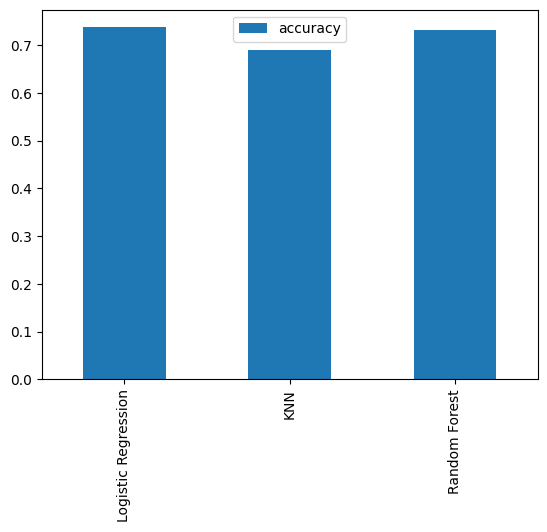

In [34]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()

In [35]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1,20,2)}

In [36]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [37]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.615848211066026}

In [38]:
rs_log_reg.score(X_test, y_test)

0.7458962573867367

In [39]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier()
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [40]:
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [41]:
rs_rf.score(X_test, y_test)

0.7294812869336835

In [42]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

#  Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=2)

# Fit hyperparameter search for logisticRegression
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..........C=9.999999999999999e-05, solver=liblinear; total time=   0.1s
[CV] END ..........C=9.999999999999999e-05, solver=liblinear; total time=   0.5s
[CV] END ..........C=9.999999999999999e-05, solver=liblinear; total time=   0.0s
[CV] END ..........C=9.999999999999999e-05, solver=liblinear; total time=   0.0s
[CV] END ..........C=9.999999999999999e-05, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00018873918221350977, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00035622478902624444, solver=liblinear; total time=   0.0s
[CV] END .........C=0.00035622478902624444, sol

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=2)

In [43]:
# Check the best hyperparameters
gs_log_reg.best_params_

{'C': 0.7278953843983147, 'solver': 'liblinear'}

In [44]:
# Evaluate the hyperparameter search for LogisticRegression
gs_log_reg.score(X_test, y_test)

0.7458962573867367

## Evaluating our tuned machine learing classifier, beyond accuracy
* ROC curve and AUC score
* Confusion matrix
* Classification report
* Precision
* Recall
* F1-score

In [45]:
# Make predictions with tuned model
y_preds = gs_log_reg.predict(X_test)

In [46]:
y_preds

array([0, 0, 1, ..., 0, 0, 0])

In [47]:
y_test

,target
7280,1
5141,0
1247,0
1040,0
2277,0
...,...
5264,1
4756,1
960,0
871,0


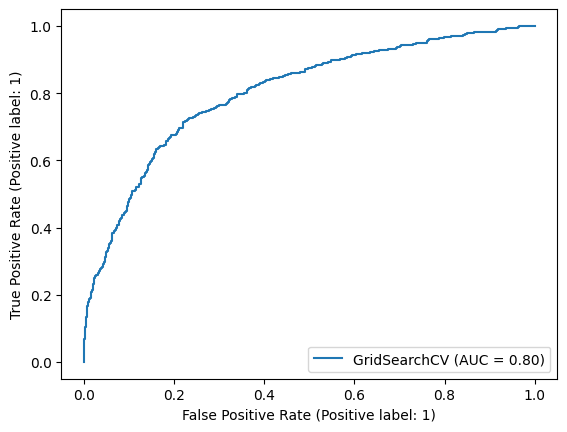

In [48]:
# Plot ROC curve and calculate AUC metric
RocCurveDisplay.from_estimator(gs_log_reg, X_test, y_test);

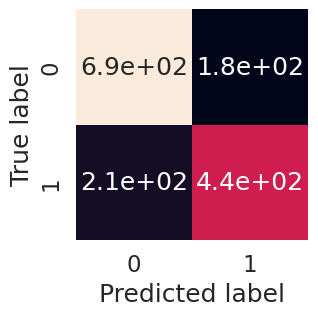

In [49]:
sns.set(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True,
                     cbar=False)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plot_conf_mat(y_test, y_preds)

In [50]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       875
           1       0.71      0.68      0.70       648

    accuracy                           0.75      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.74      0.75      0.75      1523



### Calculate evaluation metrics using cross-validation